In [1]:
using Pkg; Pkg.activate(".")

  Activating project at `~/Research/Oceananigans-Tutorial-CFP`


In [2]:
using Oceananigans
using Oceananigans.Units

[ Info: Oceananigans will use 6 threads


In [39]:
Nx, Nz = 200, 100

architecture = CPU()

H  = 1kilometers
Lx = 500kilometers

underlying_grid = RectilinearGrid(architecture,
                                  size = (Nx, Nz),
                                  x = (-Lx/2, Lx/2),
                                  z = (-H, 0),
                                  halo = (4, 4), # start with this commented out
                                  topology = (Periodic, Flat, Bounded))

200×1×100 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── Periodic x ∈ [-250000.0, 250000.0) regularly spaced with Δx=2500.0
├── Flat y
└── Bounded  z ∈ [-1000.0, 0.0]        regularly spaced with Δz=10.0

In [40]:
h₀ = H/20
width = 5kilometers
bump(x, y) = - H + h₀ * exp(-x^2 / 2width^2)

grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bump))

200×1×100 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo:
├── immersed_boundary: GridFittedBottom(min(h)=-1.00e+03, max(h)=-9.52e+02)
├── underlying_grid: 200×1×100 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── Periodic x ∈ [-250000.0, 250000.0) regularly spaced with Δx=2500.0
├── Flat y
└── Bounded  z ∈ [-1000.0, 0.0]        regularly spaced with Δz=10.0

The $M_2$ tide.

In [41]:
T₂ = 12.421hours
const ω₂ = 2π / T₂

0.00014051439111137024

In [5]:
coriolis = FPlane(latitude = -45)

# excursion parameter
ε = 0.1 # U / (ω * width)
U_tidal = ε * ω₂ * width

const tidal_forcing_amplitude = U_tidal * (coriolis.f^2 - ω₂^2) / ω₂

@inline tidal_forcing(x, y, z, t) = tidal_forcing_amplitude * cos(ω₂ * t)

tidal_forcing_amplitude = -4.554652937377061e-6


tidal_forcing (generic function with 1 method)

In [6]:
gravitational_acceleration = 9.81
gravity_wave_speed = sqrt(gravitational_acceleration * grid.Lz)
gravity_wave_timescale = 0.2 * minimum_xspacing(grid) / gravity_wave_speed

tidal_timescale = 1 / ω₂

Δt = 0.05 * tidal_timescale

@show prettytime(Δt)

prettytime(Δt) = "5.931 minutes"


"5.931 minutes"

In [24]:
model = HydrostaticFreeSurfaceModel(grid = grid,
                                    free_surface = ImplicitFreeSurface(),
                                    coriolis = coriolis,
                                    buoyancy = BuoyancyTracer(),
                                    tracers = :b,
                                    momentum_advection = WENO(),
                                    tracer_advection = WENO(),
                                    forcing = (u = tidal_forcing,))

HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── grid: 250×1×120 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
├── free surface: ImplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── solver: MatrixImplicitFreeSurfaceSolver
└── coriolis: FPlane{Float64}

In [25]:
simulation = Simulation(model, Δt=Δt, stop_time=7days)

Simulation of HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 5.931 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 7 days
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [26]:
wizard = TimeStepWizard(cfl=0.2, max_change=1.1, max_Δt=Δt)

simulation.callbacks[:wizard] = Callback(wizard, IterationInterval(20))

Callback of TimeStepWizard(cfl=0.2, max_Δt=355.835, min_Δt=0.0) on IterationInterval(20)

In [27]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)

    elapsed = 1e-9 * (time_ns() - wall_clock[])

    msg = @sprintf("iteration: %d, time: %s, wall time: %s, max|w|: %6.3e, m s⁻¹, next Δt: %s\n",
                   iteration(sim), prettytime(sim), prettytime(elapsed),
                   maximum(abs, sim.model.velocities.w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    @info msg

    return nothing
end

simulation.callbacks[:print_progress] = Callback(print_progress, IterationInterval(100))

Callback of print_progress on IterationInterval(100)

In [28]:
b = model.tracers.b
u, v, w = model.velocities

U = Field(Average(u))

u′ = u - U

N² = ∂z(b)

S² = @at (Center, Center, Face) ∂z(u)^2 + ∂z(v)^2

Ri = N² / S²

BinaryOperation at (Center, Center, Face)
├── grid: 250×1×120 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    / at (Center, Center, Face)
    ├── ∂zᶜᶜᶠ at (Center, Center, Face) via identity
    │   └── 250×1×120 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU
    └── + at (Center, Center, Face)
        ├── ^ at (Center, Center, Face)
        │   ├── ∂zᶠᶜᶠ at (Center, Center, Face) via ℑxᶜᵃᵃ
        │   │   └── 250×1×120 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
        │   └── 2
        └── ^ at (Center, Center, Face)
            ├── ∂zᶜᶠᶠ at (Center, Center, Face) via ℑyᵃᶜᵃ
            │   └── 250×1×120 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
            └── 2

In [29]:
name = "barotropic_tide"

simulation.output_writers[:fields] = JLD2OutputWriter(model, (; Ri, N², u′, u, w, b),
                                                      schedule = TimeInterval(15minutes),
                                                      with_halos = false,
                                                      filename = name,
                                                      overwrite_existing = true)

JLD2OutputWriter scheduled on TimeInterval(15 minutes):
├── filepath: ./barotropic_tide.jld2
├── 6 outputs: (Ri, N², u′, u, w, b)
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

In [30]:
# Initial conditions
uᵢ(x, y, z) = U_tidal

N² = 4e-5  # [s⁻²] buoyancy frequency / stratification
ϵb = 1e-7  # noise amplitude
bᵢ(x, y, z) = N² * z + ϵb * randn()

set!(model, u=uᵢ, b=bᵢ)

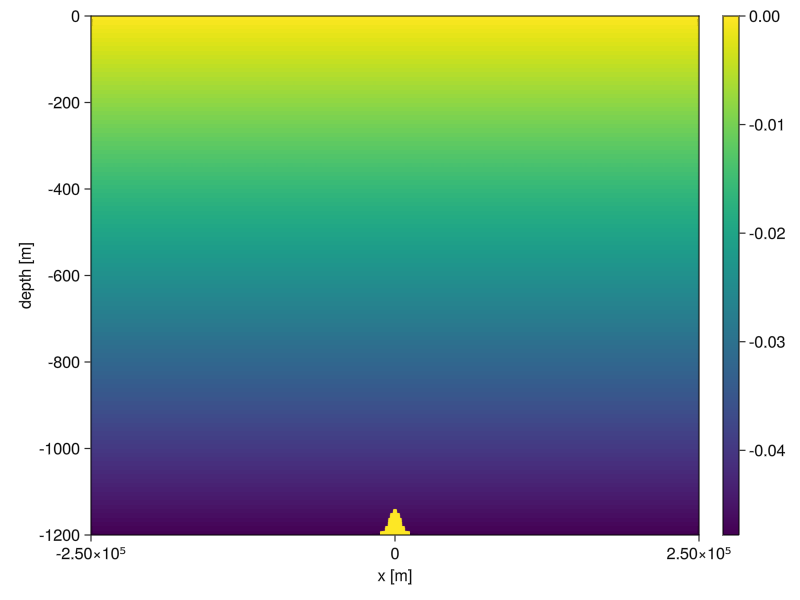

In [31]:
using GLMakie
Makie.inline!(true)

fig = Figure()

ax = Axis(fig[1, 1],
          xlabel = "x [m]",
          ylabel = "depth [m]")

x, y, z = nodes(b)

hm = heatmap!(ax, x, z, interior(b, :, 1, :))
Colorbar(fig[1, 2], hm)

fig

In [32]:
run!(simulation)

[ Info: Initializing simulation...
[ Info: iteration: 0, time: 0 seconds, wall time: 14.606 seconds, max|w|: 7.026e-04, m s⁻¹, next Δt: 5.931 minutes
[ Info:     ... simulation initialization complete (7.481 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (10.166 seconds).
[ Info: iteration: 100, time: 3.330 hours, wall time: 29.367 seconds, max|w|: 7.803e-03, m s⁻¹, next Δt: 11.120 seconds
[ Info: iteration: 200, time: 3.477 hours, wall time: 9.989 seconds, max|w|: 4.586e-03, m s⁻¹, next Δt: 3.225 seconds
[ Info: iteration: 300, time: 3.566 hours, wall time: 10.094 seconds, max|w|: 4.999e-03, m s⁻¹, next Δt: 3.198 seconds
[ Info: iteration: 400, time: 3.655 hours, wall time: 9.548 seconds, max|w|: 5.703e-03, m s⁻¹, next Δt: 3.171 seconds
[ Info: iteration: 500, time: 3.742 hours, wall time: 10.012 seconds, max|w|: 7.850e-03, m s⁻¹, next Δt: 3.145 seconds
[ Info: iteration: 600, time: 3.829 hours, wall time: 9.858 seconds, max|w|: 6.296e-03, m

LoadError: InterruptException:

In [33]:
saved_output_filename = name * ".jld2"

u_t  = FieldTimeSeries(saved_output_filename, "u")
u′_t = FieldTimeSeries(saved_output_filename, "u′")
w_t  = FieldTimeSeries(saved_output_filename, "w")
N²_t = FieldTimeSeries(saved_output_filename, "N²")

times = u_t.times

InterruptException: InterruptException:

In [34]:
xu,  yu,  zu  = nodes(u_t[1])
xw,  yw,  zw  = nodes(w_t[1])
xN², yN², zN² = nodes(N²_t[1])

LoadError: UndefVarError: u_t not defined

In [37]:
using GLMakie
using Oceananigans.Grids: peripheral_node

n = Observable(1)

title = @lift @sprintf("t = %s", prettytime(times[$n]))

is_oceanᶠᶜᶜ = [!peripheral_node(i, 1, k, grid, Face(), Center(), Center()) for i=1:grid.Nx, k=1:grid.Nz]
is_oceanᶜᶜᶠ = [!peripheral_node(i, 1, k, grid, Center(), Center(), Face()) for i=1:grid.Nx, k=1:grid.Nz+1]
        
u′ₙ = @lift ifelse.(is_oceanᶠᶜᶜ .== 0, NaN, interior(u′_t[$n], :, 1, :))
wₙ  = @lift ifelse.(is_oceanᶜᶜᶠ .== 0, NaN, interior( w_t[$n], :, 1, :))
N²ₙ = @lift ifelse.(is_oceanᶜᶜᶠ .== 0, NaN, interior(N²_t[$n], :, 1, :))

axis_kwargs = (xlabel = "x [m]",
               ylabel = "z [m]",
               limits = ((-Lx/2, Lx/2), (-H, 0)),
               titlesize = 20)

ulim   = maximum(abs, u_t[end])
wlim   = maximum(abs, w_t[end])
N²lims = minimum(N²_t[end]), maximum(N²_t[end])

fig = Figure(resolution = (600, 1100))

ax_u = Axis(fig[2, 1];
            title = "u′-velocity", axis_kwargs...)

ax_w = Axis(fig[3, 1];
            title = "w-velocity", axis_kwargs...)

ax_N² = Axis(fig[4, 1];
             title = "stratification", axis_kwargs...)

fig[1, :] = Label(fig, title, fontsize=24, tellwidth=false)

hm_u = heatmap!(ax_u, xu, zu, u′ₙ;
                colorrange = (-ulim, ulim),
                colormap = :balance)
Colorbar(fig[2, 2], hm_u)

hm_w = heatmap!(ax_w, xw, zw, wₙ;
                colorrange = (-wlim, wlim),
                colormap = :balance)
Colorbar(fig[3, 2], hm_w)

hm_N² = heatmap!(ax_N², xN², zN², N²ₙ;
                 colorrange = N²lims,
                 colormap = :thermal)
Colorbar(fig[4, 2], hm_N²)

fig

LoadError: LoadError: InterruptException:
in expression starting at In[37]:5

In [38]:
@info "Making an animation from saved data..."

frames = 1:length(times)

record(fig, name * ".mp4", frames, framerate=24) do i
    msg = string("Plotting frame ", i, " of ", frames[end])
    print(msg * " \r")
    n[] = i
end

[ Info: Making an animation from saved data...


LoadError: UndefVarError: times not defined